In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
import random
from time import sleep
import copy
import sys

from collections import deque #collections.deque()#当deque元素已满且有新元素从一端“入队”时，数量相同的旧元素将从另一端“出队” (被移除)。
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D
from tensorflow.keras.optimizers import Adam

import time
startTime=time.time()

In [2]:
#以下参数用于图形显示
#color mapping
BLACK = 0
GRAY = 1
BLUE = 2
RED = 3
GREEN = 4

# RGB color value table
COLOR_MAP = { 
    BLACK: [0.0, 0.0, 0.0], #三个通道均是0代表黑色、均是1代表白色、仅1个为1其它为0代表三原色之一、均是0.5代表灰色
    GRAY: [0.5, 0.5, 0.5],
    BLUE: [0.0, 0.0, 1.0],
    RED: [1.0, 0.0, 0.0],
    GREEN: [0.0, 1.0, 0.0],
}

In [3]:
# Action mapping
NOOP = 0
UP = 1
DOWN = 2
LEFT = 3
RIGHT = 4

In [4]:
class BridgeSpanEnv(gym.Env):
    def __init__(self, Min_length=10,Max_length=800,step_length=10,max_steps=200):
        self.Min_length=Min_length
        self.Max_length=Max_length
        self.step_length=step_length
        self.max_steps=max_steps
        self.Material_Type=3 #材料类型（混0、钢混1、钢2）
        
        self.state_pos_dict = np.arange(self.Min_length,self.Max_length+self.step_length,self.step_length) #state_pos_dict为跨径[10 20 30...780 790 800]
        self.observation_space = gym.spaces.Discrete( self.Material_Type*len(self.state_pos_dict) ) #Discrete类表示离散空间，Box类为连续空间。
        self.states=np.arange(self.observation_space.n)  #状态索引states=[ 0  1  2  3 ~ 237 238 239]
        self.state=random.choice(self.states)  #state是状态索引号，初始值随机选择

        self.action_space = gym.spaces.Discrete(5) #Discrete类表示离散空间，Box类为连续空间
        self.actions = [NOOP, UP, DOWN, LEFT, RIGHT] #action是动作索引号
        self.action_pos_dict = {  #action_pos_dict解释动作的具体坐标操作（向下为正x、向右为正y）
            NOOP: [0, 0], #原地不动
            UP: [-1, 0],  #竖向向上移动1格
            DOWN: [1, 0], #竖向向下移动1格
            LEFT: [0, -self.step_length], #水平向左移动，跨径减少step_length米
            RIGHT: [0, self.step_length], #水平向右移动，跨径增加step_length米
        }
        #结果{0: [0, 0], 1: [-1, 0], 2: [1, 0], 3: [0, -10], 4: [0, 10]}
        
        self.step_num = 0  # 计数
        self.done = False
        self.truncated= False #这个参数暂无用途
        self.info = {}

        #以下属性用于图形显示
        self.viewer = None
        self.img_shape = [16*self.Material_Type, 16*len(self.state_pos_dict), 3] #竖向像素点数目48*水平向像素点数目1280（例如高清格式为1080*1920）

    def reset(self):
        self.state=random.choice(self.states) #state是状态索引号
        number_of_rows, span=self.state_to_grid(self.state) #返回坐标：第几行0、1、2，跨径10~800m
        self.info = {"number_of_rows(0=concrete、1=composite、2=steel)": number_of_rows,"span(m)":span} 
        self.step_num = 0
        self.done = False
        self.truncated= False
        return self.state, self.info

    def state_to_grid(self,the_state): #索引号变换为坐标（第几行0、1、2，跨径10~800m）
        number_of_rows=the_state//len(self.state_pos_dict) #第几行（混0、钢混1、钢2）
        span=self.state_pos_dict[the_state%len(self.state_pos_dict)] #跨径
        return number_of_rows, span    
    
    def grid_to_state(self,number_of_rows, span): #坐标（第几行0、1、2，跨径10~800m）变换为索引号
        the_state=np.where(self.state_pos_dict == span)[0][0]+number_of_rows*80
        return the_state       
    
    def step(self, action): #action是动作索引号
        number_of_rows, span=self.state_to_grid(self.state) #返回坐标：第几行0、1、2，跨径10~800m
        
        next_number_of_rows = number_of_rows + self.action_pos_dict[action][0] #动作执行后的坐标计算
        next_span = span + self.action_pos_dict[action][1] #动作执行后的坐标计算
        
        if next_number_of_rows < 0 or next_number_of_rows > 2:
            next_number_of_rows =number_of_rows #超出范围取边界值
        
        if next_span < self.Min_length or next_span > self.Max_length:
            next_span =span #超出范围取边界值
            
        self.state=self.grid_to_state(next_number_of_rows, next_span) #动作执行后的状态索引号.
        self.info = {"number_of_rows(0=concrete、1=composite、2=steel)": next_number_of_rows,"span(m)":next_span} #动作执行后的坐标
        
        # 计算回报
        if next_number_of_rows==0: #混凝土材料
            reward= (40*next_span**1.2+250)+(next_span**(1/2-1)*50000) #桥梁单价
        elif next_number_of_rows==1: #钢混组合材料
            reward= (90*next_span**1.07+500)+(next_span**(1/2-1)*45000) #桥梁单价
        elif next_number_of_rows==2: #钢材料
            reward= (140*next_span**1+2000)+(next_span**(1/2-1)*40000) #桥梁单价
            
        self.step_num += 1
        # 是否到达最大次数
        if self.step_num >= self.max_steps:
            self.done = True

        return self.state, -reward, self.done, self.truncated, self.info


    #以下2个函数用于图形显示
    def gridarray_to_image(self, img_shape=None): #图形显示
        if img_shape is None:
            img_shape = self.img_shape
        observation = np.random.randn(*img_shape) * 0.0 #列表或元组、字典前面加上星号(*)用于函数调用时解包参数
        scale_x = int(observation.shape[0] / 3) #竖向比例
        scale_y = int(observation.shape[1] / len(self.state_pos_dict)) #水平向比例
        for i in range(self.Material_Type):
            for j in range(len(self.state_pos_dict)):
                pixel_value = COLOR_MAP[(i+j)%2] #“[(i+j)%2]”形成黑灰间隔棋盘
                observation[
                    i * scale_x : (i + 1) * scale_x,
                    j * scale_y : (j + 1) * scale_y,
                    ] = pixel_value

        number_of_rows, span=self.state_to_grid(self.state) #返回坐标：第几行0、1、2，跨径10~800m
        number_of_columns=np.where(self.state_pos_dict == span)[0][0] #跨径变换为列数
        observation[
            number_of_rows * scale_x:(number_of_rows+1) * scale_x,
            number_of_columns * scale_y:(number_of_columns+1) * scale_y
            ]=COLOR_MAP[3] #智能体位置颜色标示
        return (255 * observation).astype(np.uint8) #gym图像显示仅支持0~255格式，0~1格式显示失败

    def render(self, mode="human", close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        img = self.gridarray_to_image()
        if mode == "rgb_array":
            return img
        elif mode == "human":
            from gym.envs.classic_control import rendering

            if self.viewer is None:
                self.viewer = rendering.SimpleImageViewer()
            self.viewer.imshow(img)


In [5]:
class DQNAgent:
    def __init__(self, state_size=[48,1280,3], action_size=5): #state_size图像尺寸，action_size= 5(动作的数目)
        self.state_size = state_size
        self.action_size = action_size
        
        self.memory = deque(maxlen=1200) #记忆体使用队列实现，队列满后根据插入顺序自动删除老数据
        self.gamma = 0    # discount rate，见P122第二行公式
        self.epsilon = 0.8  # exploration rate，贪婪学习系数，见P122第8.2.5.2节
        
        self.model = self._build_model()
        self.loss_list = []

    def _build_model(self): #神经网络的功能：输入Observation（state），输出各个action（预测值）。网络参数量大，效果好、耗时影响有限
        # Neural Net for Deep-Q learning Model
        model = Sequential() # 顺序模型，搭建神经网络。图像像素值0~255，不需要转换到0~1也能够训练成功
        model.add(Conv2D(16, (4, 4), activation='relu', strides=4, input_shape=self.state_size))
        model.add(Conv2D(32, (4, 4), activation='relu', strides=4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu')) 
        model.add(Dense(self.action_size, activation='linear')) #每个动作都输出一个Q值
        model.compile( loss='mse',optimizer=Adam(learning_rate=0.01) ) # 指定损失函数（loss='mse'均方误差）、优化器
        #model.compile( loss='mse',optimizer='rmsprop' ) # 指定损失函数（loss='mse'均方误差）、优化器
        return model #本质上神经网络就是Q learning中的Q表，给出一个状态，就能得到全部动作的值。见P121图8.1
    
    def remember(self, state, action, reward, next_state):# 在记忆体（经验回放池）中保存具体某一时刻的当前状态信息
        self.memory.append((state, action, reward, next_state))
    
    def act(self, state):
        #采用贪婪策略来玩游戏。以概率E来随机每步行动，以概率（1-E）来根据神经网络预测结果行动（即用这个预测结果来一步行动玩游戏）
        if np.random.rand() <= self.epsilon: # 如果随机数（0-1之间）小于epsilon，则随机返回一个动作
            return random.randrange(self.action_size) # 随机返回动作0或1。return语句一旦执行，将退出函数，return之后的代码将没有任何意义。
        act_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0) 
        # print("model.predict act_values:",act_values)
        return np.argmax(act_values[0])  # returns action 返回值最大的索引，而不是最大值本身。
    
    #def replay(self, batch_size):# 记忆回放，训练神经网络模型
    def replay(self):# 记忆回放，训练神经网络模型
        for state, action, reward, next_state in self.memory:
            target = (reward + self.gamma * np.max(self.model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0])) #np.max(即np.amax)返回每一列元素的最大值
            target_f = self.model.predict(np.expand_dims(state, axis=0), verbose=0) #生成预测的Q值向量（长度=动作空间数量）
            target_f[0][action] = target #套用模型预测Q值向量外壳，修改Q值，生成标签
            history =self.model.fit(np.expand_dims(state, axis=0), target_f, epochs=1, verbose=0) #训练神经网络。fit 中的 verbose日志显示：0 静默；1 为输出进度条记录。
            self.loss_list.append(history.history['loss'])

    def load(self, name): # 加载模型
        self.model.load_weights(name)
    
    def save(self, name='.\\h5\\DQN_01.h5'):# 保存模型
        self.model.save_weights(name)

In [61]:
#DQN训练
env = BridgeSpanEnv()
agent = DQNAgent(env.img_shape, env.action_space.n) 
agent.model.summary()
EPISODES = 800 

for e in range(EPISODES): # 循环学习次数，每次学习都需要初始化环境
    print("episode:",e)
    env.reset() # 环境初始化
    state=env.render(mode = "rgb_array")
    done = False

    while not done: #当done为false时一直循环，直到done为true
        action = agent.act(state) #采用贪婪策略来玩游戏。以概率E来随机每步行动，以概率（1-E）来根据神经网络预测结果行动（即用这个预测结果来一步行动玩游戏）
        next_state, reward, done, _,_ = env.step(action) 
        next_state=env.render(mode = "rgb_array")
            
        agent.remember(state, action, reward, next_state) # 放入记忆体。
        state = next_state
           
    agent.replay() #训练神经网络
    agent.save(name='.\\h5\\DQN%s.h5'%(e))
    np.savetxt('.\\h5\\history.history.loss.txt', agent.loss_list)

endTime=time.time()
print('How many minutes:',(endTime-startTime)/60) #10m/episode

# 误差图示
plt.title("Loss") 
plt.xlabel("times")
plt.ylabel("Loss")
plt.plot(agent.loss_list[-40000:])
plt.show()

#240个状态
states=[]
for i in range(240):
    env.state=i
    state=env.render(mode = "rgb_array")
    states.append(state)
states=np.array(states)
plt.imshow(states[239])
plt.show()

#agent.load(name='.\\h5\\DQN82.h5')
q_table = agent.model.predict(states, verbose=0) 
print(q_table)

#Q表图示
plt.plot(-q_table[80:160,0:3])
plt.show()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 24, 640, 2)        56        
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 320, 2)        38        
                                                                 
 conv2d_30 (Conv2D)          (None, 6, 160, 4)         76        
                                                                 
 conv2d_31 (Conv2D)          (None, 3, 80, 4)          148       
                                                                 
 flatten_7 (Flatten)         (None, 960)               0         
                                                                 
 dense_14 (Dense)            (None, 240)               230640    
                                                                 
 dense_15 (Dense)            (None, 5)                

KeyboardInterrupt: 

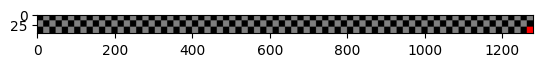

[[ -16697.492  -16697.014  -15790.217  -16699.635  -12890.149]
 [ -12894.05   -12893.401  -12795.404  -16706.512  -11760.324]
 [ -11751.924  -11752.734  -12142.655  -12893.162  -11505.328]
 ...
 [-112636.43  -114001.62  -112636.    -111243.53  -114039.95 ]
 [-114029.414 -115531.52  -114038.11  -112645.27  -115438.17 ]
 [-115422.3   -117066.375 -115418.42  -114045.49  -115419.11 ]]


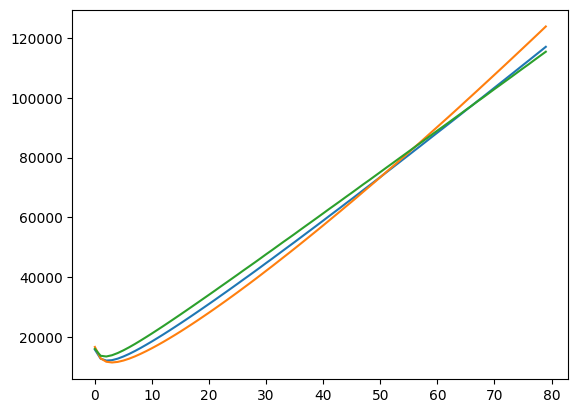

In [7]:
env = BridgeSpanEnv()
agent = DQNAgent(env.img_shape, env.action_space.n) 
agent.load(name='.\\DQN.h5')

#240个状态
states=[]
for i in range(240):
    env.state=i
    state=env.render(mode = "rgb_array")
    states.append(state)
states=np.array(states)
plt.imshow(states[239])
plt.show()

q_table = agent.model.predict(states, verbose=0) 
print(q_table)

#Q表图示
plt.plot(-q_table[80:160,0:3])
plt.show()

episode= 0
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 40}
list_of_actions= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [83, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


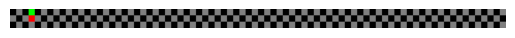

episode= 1
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 490}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [208, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


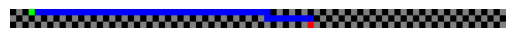

episode= 2
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 400}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


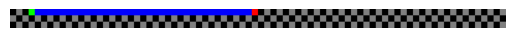

episode= 3
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 670}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


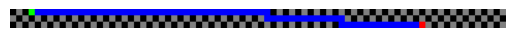

episode= 4
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 720}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


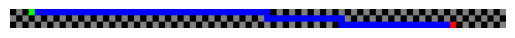

episode= 5
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 160}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


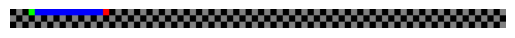

episode= 6
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 150}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


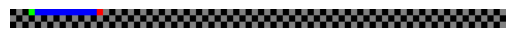

episode= 7
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 360}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [195, 115, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


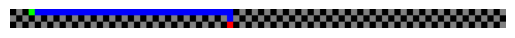

episode= 8
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 340}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [113, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


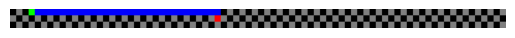

episode= 9
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 220}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [101, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


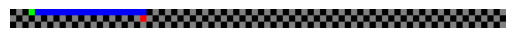

episode= 10
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 440}
list_of_actions= [1, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [203, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


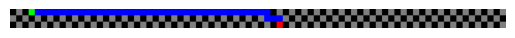

episode= 11
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 20}
list_of_actions= [1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [161, 81, 82, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


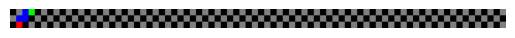

episode= 12
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 690}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


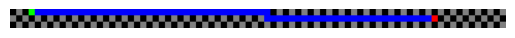

episode= 13
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 630}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


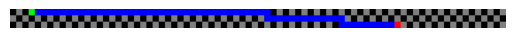

episode= 14
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 20}
list_of_actions= [4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


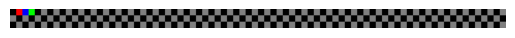

episode= 15
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 50}
list_of_actions= [1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [164, 84, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


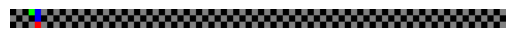

episode= 16
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 620}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


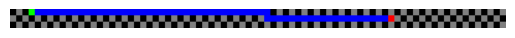

episode= 17
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 380}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [117, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


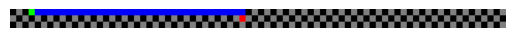

episode= 18
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 350}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


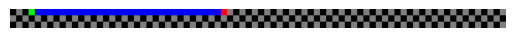

episode= 19
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 600}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [59, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


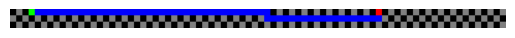

episode= 20
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 330}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [112, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


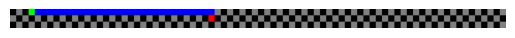

episode= 21
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 530}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


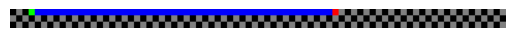

episode= 22
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 310}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [190, 110, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


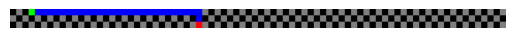

episode= 23
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 220}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [101, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


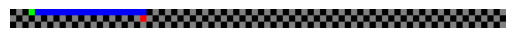

episode= 24
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 210}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


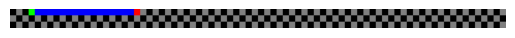

episode= 25
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 720}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


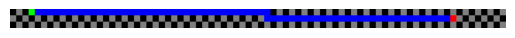

episode= 26
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 570}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


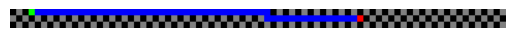

episode= 27
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 790}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1]
list_of_states= [78, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


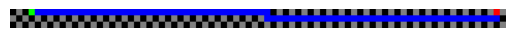

episode= 28
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 200}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [99, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


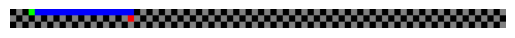

episode= 29
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 160}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [175, 95, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


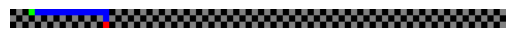

episode= 30
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 710}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


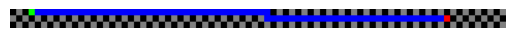

episode= 31
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 470}
list_of_actions= [3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


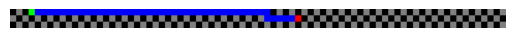

episode= 32
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 430}
list_of_actions= [1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [202, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


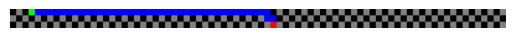

episode= 33
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 10}
list_of_actions= [4, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [80, 81, 82, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


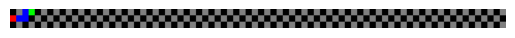

episode= 34
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 500}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [209, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


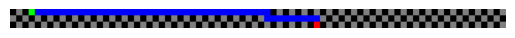

episode= 35
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 800}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1]
list_of_states= [159, 239, 238, 237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


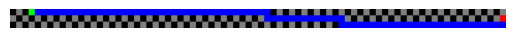

episode= 36
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 110}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [170, 90, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


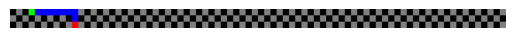

episode= 37
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 310}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [110, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


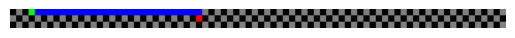

episode= 38
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 300}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [109, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


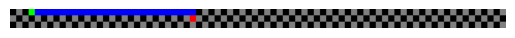

episode= 39
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 600}
list_of_actions= [3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


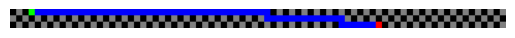

episode= 40
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 140}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [93, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


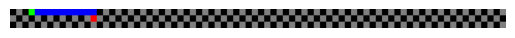

episode= 41
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 740}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


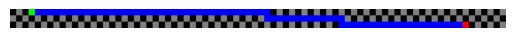

episode= 42
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 160}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [175, 95, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


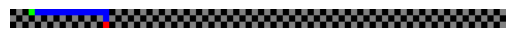

episode= 43
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 580}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


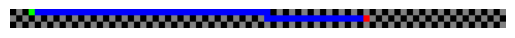

episode= 44
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 530}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


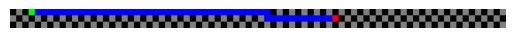

episode= 45
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 320}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [191, 111, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


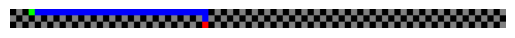

episode= 46
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 550}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


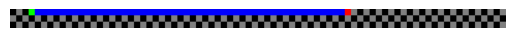

episode= 47
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 630}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


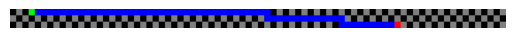

episode= 48
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 710}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [70, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


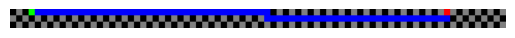

episode= 49
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 330}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


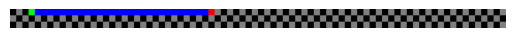

episode= 50
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 640}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


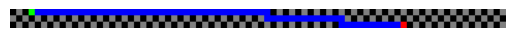

episode= 51
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 300}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [189, 109, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


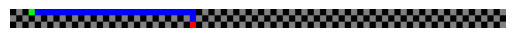

episode= 52
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 420}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


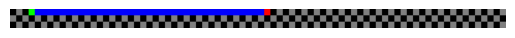

episode= 53
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 370}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [116, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


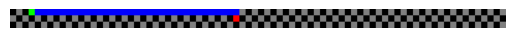

episode= 54
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 550}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


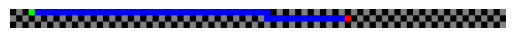

episode= 55
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 60}
list_of_actions= [1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [165, 85, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


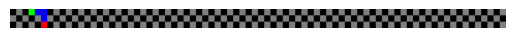

episode= 56
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 620}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [61, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


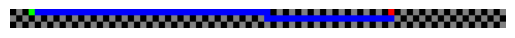

episode= 57
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 210}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [100, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


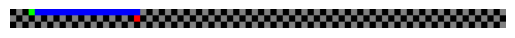

episode= 58
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 540}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


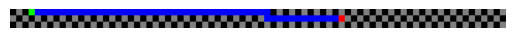

episode= 59
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 710}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [70, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


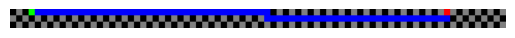

episode= 60
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 370}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [196, 116, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


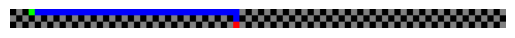

episode= 61
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 160}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [175, 95, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


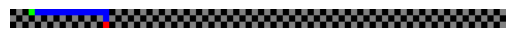

episode= 62
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 220}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [181, 101, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


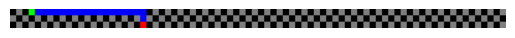

episode= 63
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 440}
list_of_actions= [3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


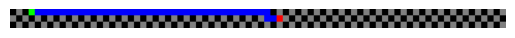

episode= 64
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 770}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1]
list_of_states= [76, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


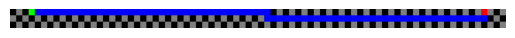

episode= 65
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 400}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


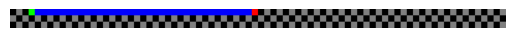

episode= 66
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 730}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [72, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


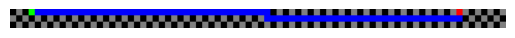

episode= 67
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 60}
list_of_actions= [1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [165, 85, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


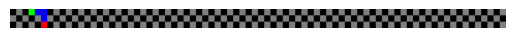

episode= 68
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 520}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


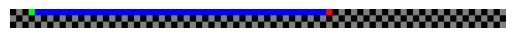

episode= 69
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 750}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


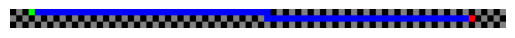

episode= 70
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 390}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [198, 118, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


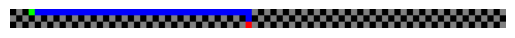

episode= 71
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 50}
list_of_actions= [1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [84, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


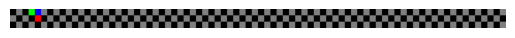

episode= 72
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 430}
list_of_actions= [1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [202, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


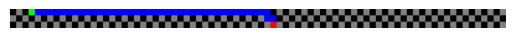

episode= 73
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 530}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


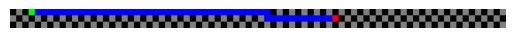

episode= 74
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 710}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


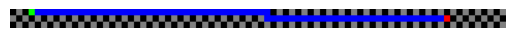

episode= 75
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 230}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


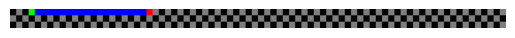

episode= 76
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 450}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


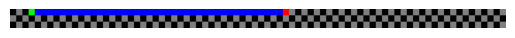

episode= 77
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 140}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


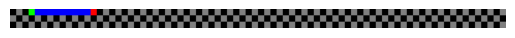

episode= 78
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 420}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


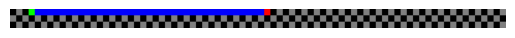

episode= 79
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 160}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [95, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


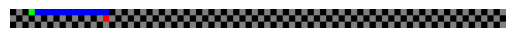

episode= 80
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 560}
list_of_actions= [3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


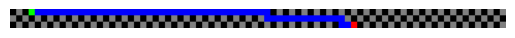

episode= 81
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 560}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


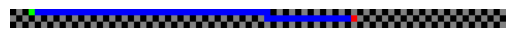

episode= 82
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 670}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


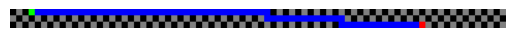

episode= 83
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 360}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [115, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


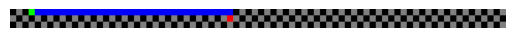

episode= 84
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 550}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


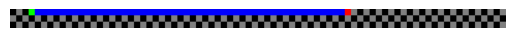

episode= 85
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 190}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


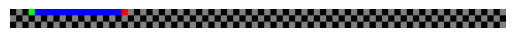

episode= 86
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 670}
list_of_actions= [2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [66, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


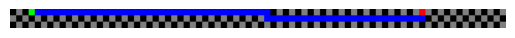

episode= 87
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 520}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


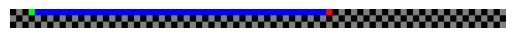

episode= 88
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 100}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [169, 89, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


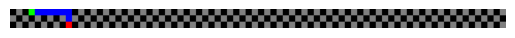

episode= 89
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 190}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


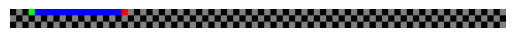

episode= 90
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 460}
list_of_actions= [1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [205, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


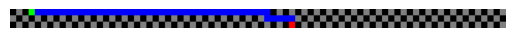

episode= 91
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 660}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


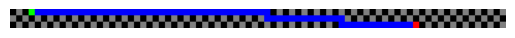

episode= 92
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 350}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [114, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


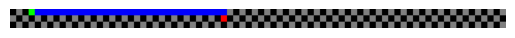

episode= 93
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 550}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


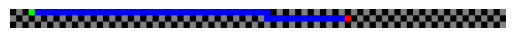

episode= 94
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 540}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


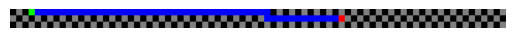

episode= 95
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 1, 'span(m)': 280}
list_of_actions= [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [107, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


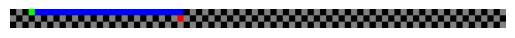

episode= 96
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 250}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


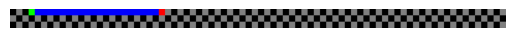

episode= 97
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 200}
list_of_actions= [1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [179, 99, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


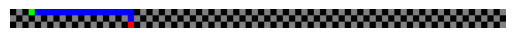

episode= 98
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 60}
list_of_actions= [3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
list_of_states= [5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


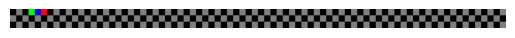

episode= 99
初始随机状态的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 2, 'span(m)': 780}
list_of_actions= [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1]
list_of_states= [237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 3, 3, 3, 3]
经济跨径的info= {'number_of_rows(0=concrete、1=composite、2=steel)': 0, 'span(m)': 40}
(48, 1280, 3)


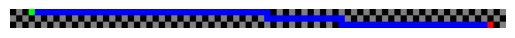

In [91]:
#单张图片示意全部状态
def image_of_all_states(frame,list_of_states,color=[255, 0, 0]): #单张图片示意全部状态
    for the_state in list_of_states:
        number_of_rows, span=env.state_to_grid(the_state) #返回坐标：第几行0、1、2，跨径10~800m
        number_of_columns=np.where(env.state_pos_dict == span)[0][0] #跨径变换为列数
        #print('the_state=',the_state,'number_of_rows=',number_of_rows,'number_of_columns=',number_of_columns)
        frame[
            number_of_rows * 16:(number_of_rows+1) * 16,
            number_of_columns * 16:(number_of_columns+1) * 16
            ]=color #智能体位置颜色标示
    return frame.astype(np.uint8)


"""Test policy performance after training"""
num_episodes = 100 #游戏轮数
env = BridgeSpanEnv(max_steps=80)
for episode in range(num_episodes):
    state, info = env.reset()
    print('episode=',episode)
    print('初始随机状态的info=',info)
    env.render()
    sleep(1) #便于观察图像
    done = False
    list_of_actions=[]
    list_of_states=[state]

    while not done: #当done为false时一直循环，直到done为true
        action = np.argmax(q_table[state]) #numpy.argmax(array, axis) 用于返回一个numpy数组中最大值的索引值。
        list_of_actions.append(action)
        state, reward, done, _, info = env.step(action)
        list_of_states.append(state)
        env.render()
        sleep(0.1) #便于观察图像

    
    # final results 
    print('list_of_actions=',list_of_actions)
    print('list_of_states=',list_of_states)
    print('经济跨径的info=',info)
    
    frame = env.render(mode="rgb_array") 
    print(frame.shape)
    frame=image_of_all_states(frame,list_of_states,color=[0, 0, 255]) #中间状态蓝色
    frame=image_of_all_states(frame,list_of_states[-1:],color=[0, 255, 0]) #终点绿色
    frame=image_of_all_states(frame,list_of_states[0:1],color=[255, 0, 0]) #起点红色
    plt.imshow(frame)
    plt.axis("off")
    #np.savetxt('q_table.txt', q_table,fmt='%d')
    plt.savefig('.\\png\\episode#%s.png'%episode, dpi=300)
    plt.show()
    

    env.render(close=True) #或者env.viewer.close()